In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as sts
import stan
import nest_asyncio
nest_asyncio.apply() 

In [2]:
# Parameters
P = [3, 5, 1, 4, 1, 2, 1, 1, 4]
N = 10 ** 3
ITER = 1000
WARMUP = 200
CHAINS = 8
SEED = 1729

In [3]:
#### GROUND TRUTH ####
np.random.seed(SEED)

# Mask-wearing
mask_wearer = np.random.binomial(1, 0.5, size=(N,))
true_mask_impact = np.random.lognormal(-1, 0.5, len(P))
true_mask_impact_rep = np.repeat(true_mask_impact, P)

# Test use
t_i = np.random.beta(8, 2, 1)  # Prob(tested | infected)
t_not_i = np.random.beta(2, 20, 1)  # Prob(tested | not-infected)
true_gamma = np.array([t_i, t_not_i])

# Test accuracy
test_sensitivity = np.random.beta(4, 3, 1)  # True positive rate
test_specificity = np.random.beta(50, 2, 1)  # True negative rate
true_lambda = np.array([test_sensitivity, test_specificity])

# Transmission rates
true_transmission_rate_mu = np.random.beta(2, 10, len(P))
true_transmission_rate_std = np.sqrt(sts.invgamma.rvs(a=100, size=len(P)))
true_transmission_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_transmission_rate_mu, true_transmission_rate_std)
])
base_rate = np.random.beta(2, 10, 1)

# Occurrence rates
true_occurrence_rate_mu = np.random.beta(2, 10, len(P))
true_occurrence_rate_std = np.sqrt(sts.invgamma.rvs(a=50, size=len(P)))
true_occurrence_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_occurrence_rate_mu, true_occurrence_rate_std)
])

# Set antigen test mean and std. error for TP and TN rates (for strong priors)

# True positive
mean_tp = 0.73000
se_tp = 0.04133

# True negative
mean_tn = 0.99680
se_tn = 0.00066

mean_rates = np.array([mean_tp, mean_tn])
se_rates = np.array([se_tp, se_tn])

In [4]:
#### SIMULATE DATA ####
data = {}
for p in range(sum(P)):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    # Impact of mask-wearing
    transmission_prob = sp.expit(sp.logit(true_transmission_rate[p]) +
                                 np.log(true_mask_impact_rep[p]) * mask_wearer)
    transmission = occurrence * np.random.binomial(1, transmission_prob)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)

# Resampling for test use
tested = y*np.random.binomial(1, true_gamma[0], N) + \
         (1-y)*np.random.binomial(1, true_gamma[1], N)
y = y[tested == 1]
X_survey = X[tested == 0].reset_index()
m_survey = mask_wearer[tested == 0]
X = X[tested == 1].reset_index()
m = mask_wearer[tested == 1]
X = X.loc[:, X.columns.str.startswith('O')]
X_survey = X_survey.loc[:, X_survey.columns.str.startswith('O')]
N = X.shape[0]
NA = X_survey.shape[0]

# Introduce false positives and negatives
y = y * np.random.binomial(1, true_lambda[0], N) + \
    (1-y) * np.random.binomial(1, (1-true_lambda[1]), N)

# Record classes
c = np.array([i + 1 for i, p in enumerate(P) for __ in range(p)])

In [5]:
# Stan model code
model_code = """
functions {
  real expit_gaussian_lpdf(real y, real logit_mu, real sigma2) {
    return log(1 / y + 1 / (1 - y)) - (logit(y) - logit_mu)^2 / (2 * sigma2);
  }
}
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> NA;                           // number of survey observations
  int<lower=0> P;                            // number of places
  int<lower=0> K;                            // number of classes
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=0, upper=1> survey[NA,P];        // activity occurrences of surveyed individuals
  real<lower=0, upper=1> mean_lambda[2];     // mean TP and TN test rates (for strong priors on tests)
  real<lower=0> se_lambda[2];                // standard error of test rates (for strong priors on tests)
  int<lower=1, upper=K> c[P];                // place classes
  int<lower=0, upper=1> m[N];                // masking-wearing
  int<lower=0, upper=1> m_survey[NA];        // masking-wearing
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> mu[K];              // class transmission means
  real<lower=0> sigma2[K];                   // class transmission variances
  real<lower=0, upper=1> gamma[2];           // Testing rates, given infected status [T|I , T|!I]
  real<lower=0, upper=1> lambda[2];          // True positive and true negative rates of tests [TP,TN]
  real<lower=0, upper=1> rho;                // underlying risk
  real iota[K];                              // intervention impacts (log)
}
transformed parameters {
  // Pre-computation for efficiency
  real log1m_theta[P] = log1m(theta);
  real log1m_theta_int[P];
  real log1m_rho = log1m(rho);
  real logit_mu[K] = logit(mu);
  real log_gamma[2];
  real log1m_gamma[2];
  real log_lambda[2];
  real log1m_lambda[2];
  real a_lambda[2];
  real b_lambda[2];

  for (p in 1:P) {
    log1m_theta_int[p] = log1m_inv_logit(logit(theta[p]) + iota[c[p]]);
  }

  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  for(i in 1:2){
    log_gamma[i] = log(gamma[i]);
    log1m_gamma[i] = log1m(gamma[i]);
    log_lambda[i] = log(lambda[i]);
    log1m_lambda[i] = log1m(lambda[i]);

    a_lambda[i] = (((1-mean_lambda[i])/se_lambda[i]^2)-(1/mean_lambda[i]))*(mean_lambda[i]^2);
    b_lambda[i] = a_lambda[i]*((1/mean_lambda[i])-1);
  }
}
model {
  // Priors
  mu ~ beta(1, 5);
  sigma2 ~ inv_gamma(10, 1);
  rho ~ beta(1, 3);
  iota ~ normal(-1, 1);
  gamma ~ uniform(0, 1);
  lambda[1] ~ beta(a_lambda[1], b_lambda[1]);
  lambda[2] ~ beta(a_lambda[2], b_lambda[2]);
  // Likelihood (classes)
  for (p in 1:P) {
    theta[p] ~ expit_gaussian(logit_mu[c[p]], sigma2[c[p]]);
  }
  // Likelihood (survey)
  for (n in 1:NA) {
    real s = 0.0;
    for (p in 1:P) {
      if (survey[n,p] == 1) {
        if (m_survey[n] == 1) {
          s += log1m_theta_int[p];
        } else {
          s += log1m_theta[p];
        }
      }
    }
    s += log1m_rho;
    target += log_sum_exp((log1m_exp(s)+log1m_gamma[1]), (s+log1m_gamma[2]));
  }
  // Likelihood (observations)
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        if (m[n] == 1) {
          s += log1m_theta_int[p];
        } else {
          s += log1m_theta[p];
        }
      }
    }
    s += log1m_rho;
    if (y[n] == 1) {
      target += log_sum_exp((log1m_exp(s) + log_gamma[1] + log_lambda[1]), (s + log_gamma[2] + log1m_lambda[2]));
    } else {
      target += log_sum_exp((s + log_gamma[2] + log_lambda[2]), (log1m_exp(s) + log_gamma[1] + log1m_lambda[1]));
    }
  }
}

""" 

In [6]:
#### SAMPLING ####
# Define model data
model_data = {
    'N': N, 'NA': NA, 'P': sum(P), 'K': len(P),
    'X': X.to_numpy(), 'y': y.to_numpy(), 'c': c, 'm': m, 'm_survey': m_survey,
    'survey': X_survey.to_numpy(), 'mean_lambda': mean_rates, 'se_lambda': se_rates,
}
# Compile model
posterior = stan.build(model_code, data=model_data, random_seed=1)

Building... This may take some time.
Messages from stanc:
  The parameter lambda has no priors.
  The parameter theta has no priors.
Done.


In [7]:
# Fit model
fit = posterior.sample(num_samples=ITER, num_warmup=WARMUP, num_chains=CHAINS)

Sampling...
    0/9600 [>---------------------------]   0%  1 sec/0     
    1/9600 [>---------------------------]   0%  1 sec/11940 
    1/9600 [>---------------------------]   0% 3 secs/22715 
    1/9600 [>---------------------------]   0% 4 secs/33676 
    1/9600 [>---------------------------]   0% 5 secs/44058 
  100/9600 [>---------------------------]   1% 6 secs/546   
  100/9600 [>---------------------------]   1% 7 secs/649   
  100/9600 [>---------------------------]   1% 8 secs/756   
  100/9600 [>---------------------------]   1% 10 secs/864   
  100/9600 [>---------------------------]   1% 11 secs/962   
  100/9600 [>---------------------------]   1% 12 secs/1073  
  100/9600 [>---------------------------]   1% 13 secs/1177  
  100/9600 [>---------------------------]   1% 14 secs/1281  
  100/9600 [>---------------------------]   1% 15 secs/1387  
  201/9600 [>---------------------------]   2% 16 secs/747   
  201/9600 [>---------------------------]   2% 17 secs/795   
  20

/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/opt/a

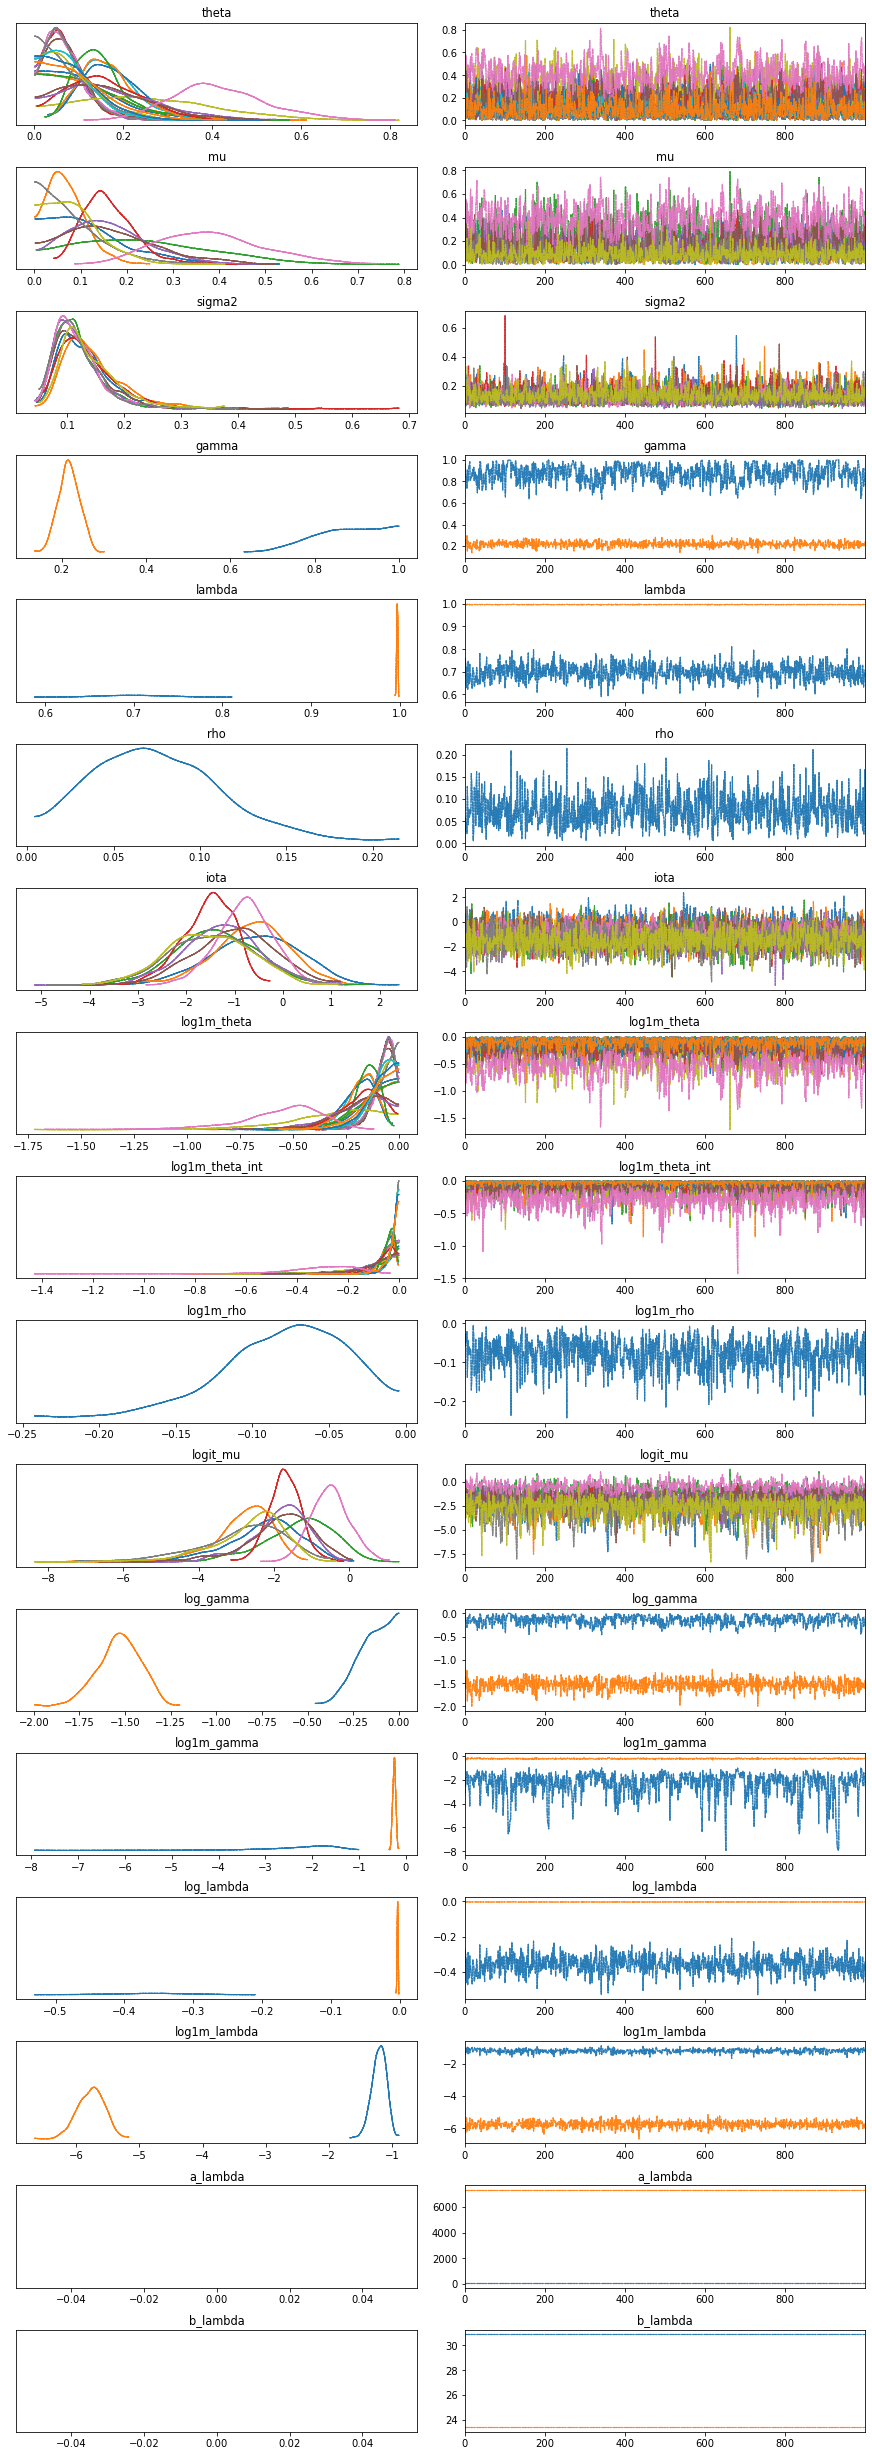

In [8]:
# Evaluate fit
arviz.plot_trace(fit);

In [9]:
# View model results summary
fit = fit.to_frame()
print("Inference on fitted model:")
fit.describe()

Inference on fitted model:


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1,theta.2,theta.3,...,log1m_gamma.1,log1m_gamma.2,log_lambda.1,log_lambda.2,log1m_lambda.1,log1m_lambda.2,a_lambda.1,a_lambda.2,b_lambda.1,b_lambda.2
count,8000.000000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.0,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,-895.977502,0.928147,5.563676e-02,6.163000,90.424000,0.0,922.762862,0.113328,0.125852,0.124041,...,-2.450463,-0.245879,-0.360832,-0.003202,-1.203937,-5.767335,8.350230e+01,7.298252e+03,3.088441e+01,2.342938e+01
std,5.483072,0.088815,1.013836e-14,0.374765,36.411344,0.0,7.504553,0.086207,0.098997,0.095122,...,1.122564,0.032279,0.049746,0.000668,0.117115,0.210091,7.319048e-12,5.084393e-10,2.096232e-12,1.417621e-12
min,-915.740388,0.325831,5.563676e-02,5.000000,31.000000,0.0,903.330059,0.000523,0.000449,0.000445,...,-7.933599,-0.357943,-0.530584,-0.005706,-1.664546,-6.662795,8.350230e+01,7.298252e+03,3.088441e+01,2.342938e+01
25%,-899.499861,0.905476,5.563676e-02,6.000000,63.000000,0.0,917.191608,0.048309,0.049441,0.051623,...,-2.829437,-0.267560,-0.394682,-0.003635,-1.276904,-5.912445,8.350230e+01,7.298252e+03,3.088441e+01,2.342938e+01
50%,-895.870914,0.958871,5.563676e-02,6.000000,63.000000,0.0,922.605871,0.096148,0.105619,0.104923,...,-2.130559,-0.244779,-0.360374,-0.003171,-1.195394,-5.755292,8.350230e+01,7.298252e+03,3.088441e+01,2.342938e+01
75%,-892.214065,0.986900,5.563676e-02,6.000000,127.000000,0.0,927.801167,0.158940,0.176967,0.175531,...,-1.696061,-0.224974,-0.326977,-0.002709,-1.120533,-5.618905,8.350230e+01,7.298252e+03,3.088441e+01,2.342938e+01
max,-882.152088,1.000000,5.563676e-02,7.000000,255.000000,0.0,953.462089,0.543593,0.612830,0.573776,...,-1.000035,-0.146056,-0.209828,-0.001278,-0.887367,-5.169108,8.350230e+01,7.298252e+03,3.088441e+01,2.342938e+01


In [10]:
# Comparison to ground truth
print('Ground truth:')
print('Theta: ', true_transmission_rate)
print('Mu', true_transmission_rate_mu)
print('Sigma', true_transmission_rate_std)
print('Rho', base_rate)
print('Iota', np.log(true_mask_impact))
print('Gamma', true_gamma)
print('Lambda', true_lambda)

Ground truth:
Theta:  [0.17895472 0.16806318 0.17607842 0.135198   0.13786847 0.13985437
 0.1451539  0.14106856 0.14955852 0.10639619 0.13644291 0.10196046
 0.12945793 0.25645276 0.38467422 0.3475288  0.39610394 0.0348667
 0.1364553  0.14712298 0.13637853 0.14234857]
Mu [0.16258462 0.13561875 0.15324919 0.11365742 0.2575691  0.36773547
 0.36300436 0.03703296 0.147411  ]
Sigma [0.09983047 0.09801375 0.10276944 0.1042145  0.09810946 0.10366531
 0.09908141 0.09960256 0.09727946]
Rho [0.11239274]
Iota [-1.88650004 -1.34178716 -1.53337799 -2.03114941 -1.25758151 -1.08825169
 -0.48418109 -1.31190212 -1.15318601]
Gamma [[0.82948175]
 [0.15916983]]
Lambda [[0.62839906]
 [0.97033825]]
